# 네이버 영화평 감성분석 - `LSTM`

In [ ]:
!pip install Konlpy > /dev/null

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 네이버 영화 리뷰 데이터로 검색
train_df = pd.read_csv('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt', sep='\t')
test_df = pd.read_csv('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt', sep='\t')

In [ ]:
print(train_df.shape, test_df.shape)
train_df.head(3)

(150000, 3) (50000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


### 1. 데이터 전처리

- train dataset

In [ ]:
# Null 데이터가 있는지 확인
train_df.isna().sum()

id          0
document    5
label       0
dtype: int64

In [ ]:
# Null 데이터 제거
train_df.dropna(how='any', inplace=True) 
train_df.shape

(149995, 3)

In [ ]:
# 중복여부 확인
train_df.document.nunique()

146182

In [ ]:
# 중복 데이터 제거
train_df.drop_duplicates(subset=['document'], inplace=True) 
train_df.shape

(146182, 3)

In [ ]:
# 긍정(1)/부정(0) 분포
train_df.label.value_counts()

0    73342
1    72840
Name: label, dtype: int64

- test dataset

In [ ]:
test_df.isna().sum()

id          0
document    3
label       0
dtype: int64

In [ ]:

test_df.dropna(how='any', inplace=True)

In [ ]:
test_df.document.nunique()

49157

In [ ]:
test_df.drop_duplicates(subset=['document'], inplace=True)
test_df.shape

(49157, 3)

In [ ]:
test_df.label.value_counts()

1    24711
0    24446
Name: label, dtype: int64

### 2. 텍스트 전처리

- trian dataset

In [ ]:
# 한글 이외의 문자는 공백으로 처리하고 strip
train_df.document = train_df.document.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ').str.strip()
train_df.head(3)

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [ ]:
# '' 만 남은 데이터 --> np.nan 으로 대체한 후 제거
train_df.document.replace('', np.nan, inplace=True)
train_df.document.isna().sum()

789

In [ ]:

train_df.dropna(how='any', inplace=True)
train_df.shape

(145393, 3)

- test dataset

In [ ]:
test_df.document = test_df.document.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ').str.strip()
test_df.document.replace('', np.nan, inplace=True)
test_df.dropna(how='any', inplace=True)
test_df.shape

(48852, 3)

- 전처리 끝난 데이터 저장

In [ ]:
train_df.to_csv('naver_movie_train_전처리완료.tsv', sep='\t', index=False)
test_df.to_csv('naver_movie_test_전처리완료.tsv', sep='\t', index=False)

### 3. 한글 형태소 분석 

In [ ]:
from konlpy.tag import Okt
okt = Okt()

In [ ]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','을','ㅋㅋ','ㅠㅠ','ㅎㅎ']

In [ ]:
from tqdm.notebook import tqdm

X_train = []
for sentence in tqdm(train_df.document):
    morphs = okt.morphs(sentence, stem=True)
    tmp_X = [word for word in morphs if word not in stopwords]
    X_train.append(tmp_X)

  0%|          | 0/145393 [00:00<?, ?it/s]

In [ ]:
print(X_train[:-3])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### 4. Keras Tokenizer --> Train/Test dataset
- 수업중 시간 관계상 train dataset을 

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts(X_train)

In [ ]:
len(t.word_index)

43118

In [ ]:
## 빈도수 상위 20,000개 단어로 인코딩 
num_words = 20000
t = Tokenizer(num_words=num_words)
t.fit_on_texts(X_train)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_train, train_df.label.values, stratify=train_df.label.values,
    test_size=0.2, random_state=seed
)

In [ ]:
X_train = t.texts_to_sequences(X_train)
X_test = t.texts_to_sequences(X_test)

In [ ]:
## 데이터 최대/평균 길이
max(len(s) for s in X_train), sum(map(len, X_train)) / len(X_train)

(70, 10.594717746788865)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 40
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
X_train.shape, X_test.shape

((116314, 40), (29079, 40))

### 5. `LSTM` 모델 정의/설정/학습

In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, GRU
from tensorflow.keras.layers import Conv1D, MaxPool1D, Dropout, GlobalMaxPool1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
model = Sequential([
                    Embedding(num_words, 120, input_length=max_len),
                    LSTM(128),
                    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 120)           2400000   
                                                                 
 lstm (LSTM)                 (None, 128)               127488    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,527,617
Trainable params: 2,527,617
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile('adam', 'binary_crossentropy', ['accuracy'])
model_path = 'best-naver-movie-model.h5'
mc = ModelCheckpoint(model_path, verbose=1, save_best_only=True)
es = EarlyStopping(patience=5)

In [ ]:
hist=model.fit(
    X_train, y_train, validation_split=0.2,
    epochs=30, batch_size=128, callbacks=[mc, es]
)

Epoch 1/30
727/727 [==============================] - ETA: 0s - loss: 0.4033 - accuracy: 0.8145
Epoch 1: val_loss improved from inf to 0.36443, saving model to best-naver-movie-model.h5
727/727 [==============================] - 159s 215ms/step - loss: 0.4033 - accuracy: 0.8145 - val_loss: 0.3644 - val_accuracy: 0.8389
Epoch 2/30
727/727 [==============================] - ETA: 0s - loss: 0.3106 - accuracy: 0.8680
Epoch 2: val_loss improved from 0.36443 to 0.36016, saving model to best-naver-movie-model.h5
727/727 [==============================] - 145s 199ms/step - loss: 0.3106 - accuracy: 0.8680 - val_loss: 0.3602 - val_accuracy: 0.8421
Epoch 3/30
727/727 [==============================] - ETA: 0s - loss: 0.2590 - accuracy: 0.8921
Epoch 3: val_loss did not improve from 0.36016
727/727 [==============================] - 144s 199ms/step - loss: 0.2590 - accuracy: 0.8921 - val_loss: 0.3709 - val_accuracy: 0.8445
Epoch 4/30
727/727 [==============================] - ETA: 0s - loss: 0.2137

In [ ]:
best_model = load_model(model_path)
best_model.evaluate(X_test, y_test)

909/909 [==============================] - 5s 4ms/step - loss: 0.3569 - accuracy: 0.8432


[0.35686299204826355, 0.8431513905525208]

### 6. 실제 데이터 예측

In [ ]:
review = '이 영화 개꿀잼ㅋㅋㅋ'

In [ ]:
import re
review = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]', '', review).strip()

morphs = okt.morphs(review, stem=True)
morphs = [word for word in morphs if word not in stopwords]
encoded = t.texts_to_sequences([morphs])
padded = pad_sequences(encoded, maxlen = max_len)
#score = best_model.predict(padded)[0][0]
score = float(best_model.predict(padded))
print('긍정' if  score > 0.5 else '부정')

NameError: ignored

- 긍정 

In [ ]:
def sentiment_predict(review, tolenizer=t, max_len=max_len): 
  review = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]', '', review).strip()
  morphs = okt.morphs(review, stem=True)
  morphs = [word for word in morphs if word not in stopwords]
  encoded = tolenizer.texts_to_sequences([morphs])
  padded = pad_sequences(encoded, maxlen = max_len)
  score = float(best_model.predict(padded))

  return f'긍정({score*100:2f}%)' if score > 0.5 else f'부정({(1-score)*100:2f}%)'

In [ ]:
sentiment_predict('이 영화 개꿀잼ㅋㅋㅋ')

'긍정(96.523285%)'

In [ ]:
sentiment_predict('이 영화 핵 노잼 ㅠㅠ')

'부정(99.110818%)'

### 7. 학습과정 시각화

In [ ]:
y_acc = hist.history['accuracy']
y_loss = hist.history['loss']
y_vacc = hist.history['val_accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

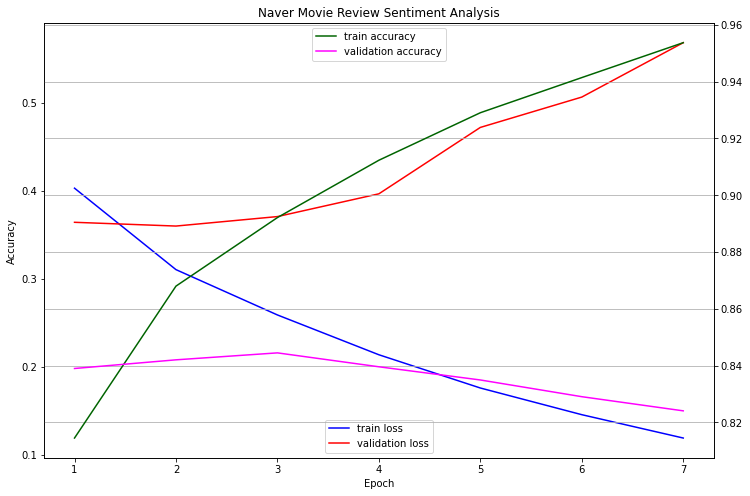

In [ ]:
# X 축 공유
# y축 좌측: loss / 우측: accuracy

import matplotlib.pyplot as plt

fig, ax0 = plt.subplots(figsize=(12,8))
ax1 = ax0.twinx()
ax0.plot(xs, y_loss, c='blue', label='train loss')
ax0.plot(xs, y_vloss, c='red',label='validation loss')
ax0.set_ylabel('Loss')
ax0.set_xlabel('Epoch')

ax1.plot(xs, y_acc, c='darkgreen', label='train accuracy')
ax1.plot(xs, y_vacc, c='magenta',label='validation accuracy')
ax0.set_ylabel('Accuracy')

ax0.legend(loc='lower center'), ax1.legend(loc='upper center')
plt.title('Naver Movie Review Sentiment Analysis')
plt.grid()
plt.show()

### 8. `Conv1D` + `GRU`

In [ ]:
model2 = Sequential([
                     Embedding(num_words, 120, input_length=max_len), 
                     Dropout(0.5),
                     Conv1D(64, 7, activation='relu'),  # 필터 수, 높이 , 활성화 함수
                     MaxPool1D(5),
                     GRU(128),
                     Dense(1, activation='sigmoid') 
])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 40, 120)           2400000   
                                                                 
 dropout_2 (Dropout)         (None, 40, 120)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 34, 64)            53824     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 6, 64)            0         
 1D)                                                             
                                                                 
 gru_1 (GRU)                 (None, 128)               74496     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                      

In [ ]:
model2.compile('adam', 'binary_crossentropy', ['accuracy'])
model2_path = 'best-naver-movie-model-conv1d-gru.h5'
mc2 = ModelCheckpoint(model2_path, verbose=1, save_best_only=True)
es2 = EarlyStopping(patience=2)

In [ ]:
hist2 = model2.fit(
    X_train, y_train, validation_split=0.2,
    epochs=30, batch_size=128, callbacks=[mc2, es2]
)

Epoch 1/30
727/727 [==============================] - ETA: 0s - loss: 0.5640 - accuracy: 0.6706
Epoch 1: val_loss improved from inf to 0.52840, saving model to best-naver-movie-model-conv1d-gru.h5
727/727 [==============================] - 17s 8ms/step - loss: 0.5640 - accuracy: 0.6706 - val_loss: 0.5284 - val_accuracy: 0.7045
Epoch 2/30
727/727 [==============================] - ETA: 0s - loss: 0.4894 - accuracy: 0.7282
Epoch 2: val_loss did not improve from 0.52840
727/727 [==============================] - 5s 7ms/step - loss: 0.4894 - accuracy: 0.7282 - val_loss: 0.5315 - val_accuracy: 0.7046
Epoch 3/30
720/727 [============================>.] - ETA: 0s - loss: 0.4446 - accuracy: 0.7549
Epoch 3: val_loss did not improve from 0.52840
727/727 [==============================] - 6s 9ms/step - loss: 0.4447 - accuracy: 0.7548 - val_loss: 0.5450 - val_accuracy: 0.7017


In [ ]:
best_model2 = load_model(model2_path)
best_model2.evaluate(X_test, y_test)

909/909 [==============================] - 3s 3ms/step - loss: 0.5285 - accuracy: 0.7040


[0.5285452008247375, 0.7040476202964783]